<a href="https://colab.research.google.com/github/DrLennon666/DAT4-students/blob/master/training_a_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TRAINING A CLASSIFIER
This is it. You have seen how to define neural networks, compute loss and make updates to the weights of the network.

Now you might be thinking,

What about data?
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

For images, packages such as Pillow, OpenCV are useful
For audio, packages such as scipy and librosa
For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful
Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![alt text](https://pytorch.org/tutorials/_images/cifar10.png)
cifar10

# Training an image classifier
We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

#1. Loading and normalizing CIFAR10
Using torchvision, it’s extremely easy to load CIFAR10.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                 download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


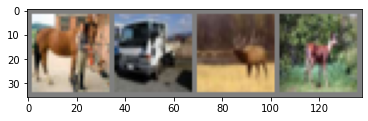

horse truck  deer  deer


In [0]:
# Function to show an image

def imshow(img):
  img = img/2 + 0.5 # unnormalize images back to [0, 1] values
  img = img.numpy() # convert Torch Tensor to Numpy array
  img = np.transpose(img, (1, 2, 0)) # transpose Numpy array from channels first to channels last

  plt.imshow(img)
  plt.show()

# get some random training images
images, labels = iter(trainloader).next() # get batch from iterator

# show images
image_grid = torchvision.utils.make_grid(images) # combines Tensors in batch into a grid, cute but will use sparingly
imshow(image_grid)

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

Recall: the resulting tensor size after a convolution is
$$[\frac{n+2p-f}{s}+1] \times [\frac{n+2p-f}{s}+1] $$

where $n$ is the original Tensor dimension, $p$ is the padding size, and $s$ is the stride length.

In [0]:
def tensor_size(n,f, p=0, s=1):
  ''' quickly determine resulting tensor size after
      a convolution. padding is 0 by default and stride
      is 1 by default. Assumes a square tensor.
      n: original tensor size
      f: kernel size
      '''
  t_size = (n + 2*p -f)/s + 1
  return (t_size, t_size)

print('first convolution:', tensor_size(32, 5))
print('second convolution:', tensor_size(28/2, 5)) # after maxpool of 2

# first fully connected layer
channels = 16
second_conv = tensor_size(28/2, 5)
channels*second_conv[0]*second_conv[1]

first convolution: (28.0, 28.0)
second convolution: (10.0, 10.0)


1600.0

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # define layers from nn.Module here
    self.conv1 = nn.Conv2d(3,6,5) # (in channels, out channels, kernel)
    self.conv2 = nn.Conv2d(6, 16, 5)
    #self.pool = nn.MaxPool2d(2,2) # 2x2 square with stride of 2
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # final layer nodes=num classes

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, (2,2), 2) # 2x2 square with stride of 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, (2,2),2)
    x = x.view(-1, 16*5*5) # reshape prior to fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # no activation function as nn.CrossEntropy contains softmax
    return x

net = Net()

In [0]:
# This network class was copied from the pytorch tutorial and is nominally
# the same as the network above. The difference being that the maxpool layer was
# defined in the __init__ function and not called through the functional module
# which really just calls nn.MaxPool2d. They both work, but choose a convention
# and stick with it going forward.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [0]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is list of [inputs, labels]
    inputs, labels = data

    # zero the paramter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i%2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d loss: %.3f' % 
            (epoch + 1, i+1, running_loss/2000))
      running_loss = 0.0
print('Finished Training')


[1,  2000 loss: 2.185
[1,  4000 loss: 1.852
[1,  6000 loss: 1.711
[1,  8000 loss: 1.605
[1, 10000 loss: 1.516
[1, 12000 loss: 1.482
[2,  2000 loss: 1.394
[2,  4000 loss: 1.379
[2,  6000 loss: 1.362
[2,  8000 loss: 1.316
[2, 10000 loss: 1.291
[2, 12000 loss: 1.296
Finished Training


Let’s quickly save our trained model:



In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch models.

#5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

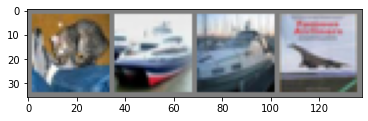

GroundTruth:    cat  ship  ship plane


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [0]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [0]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. 

As an example for `outputs[0]` the result is 

`tensor([-0.7494, -2.3089,  1.0740,  2.2455, -0.7364,  0.8663,  0.9730, -1.2540,
        -0.5367, -1.5057], grad_fn=<SelectBackward>)`

So, let’s get the index of the highest energy:

In [0]:
energy, prediction_idx = torch.max(outputs,1) # if the dimension to reduce '1' is not given a single value corresponding to the max in the mini-batch is given

print('Predicted: ', ' '.join('%5s' % classes[prediction_idx[j]]
                              for j in range(4)))

Predicted:   frog   dog   car horse


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on 10000 test images: %d %%' % (
    100 * correct / total
))

Accuracy of the network on 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i]/class_total[i]
    ))

Accuracy of plane : 58 %
Accuracy of   car : 67 %
Accuracy of  bird : 44 %
Accuracy of   cat : 18 %
Accuracy of  deer : 34 %
Accuracy of   dog : 68 %
Accuracy of  frog : 63 %
Accuracy of horse : 63 %
Accuracy of  ship : 77 %
Accuracy of truck : 59 %


Okay, so what next?

How do we run these neural networks on the GPU?

# Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The rest of this section assumes that device is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

The rest of this section assumes that device is a CUDA `device`.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

`net.to(device)`

Remember that you will have to send the inputs and targets at every step to the GPU too:

`inputs, labels = data[0].to(device), data[1].to(device)`

Why dont I notice MASSIVE speedup compared to CPU? Because your network is really small.

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # define layers from nn.Module here
    self.conv1 = nn.Conv2d(3,6,5) # (in channels, out channels, kernel)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # final layer nodes=num classes

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, (2,2), 2) # 2x2 square with stride of 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, (2,2),2)
    x = x.view(-1, 16*5*5) # reshape prior to fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # no activation function as nn.CrossEntropy contains softmax
    return x

net = Net()

# Move network to GPU
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Add loss to GPU
criterion.to(device)

CrossEntropyLoss()

In [0]:
for epoch in range(5):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)

    # zero the paramter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i%2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d loss: %.3f' % 
            (epoch + 1, i+1, running_loss/2000))
      running_loss = 0.0
print('Finished Training')

[1,  2000 loss: 2.211
[1,  4000 loss: 1.866
[1,  6000 loss: 1.689
[1,  8000 loss: 1.583
[1, 10000 loss: 1.513
[1, 12000 loss: 1.453
[2,  2000 loss: 1.350
[2,  4000 loss: 1.341
[2,  6000 loss: 1.314
[2,  8000 loss: 1.281
[2, 10000 loss: 1.256
[2, 12000 loss: 1.253
[3,  2000 loss: 1.180
[3,  4000 loss: 1.191
[3,  6000 loss: 1.172
[3,  8000 loss: 1.181
[3, 10000 loss: 1.147
[3, 12000 loss: 1.140
[4,  2000 loss: 1.079
[4,  4000 loss: 1.116
[4,  6000 loss: 1.096
[4,  8000 loss: 1.090
[4, 10000 loss: 1.090
[4, 12000 loss: 1.081
[5,  2000 loss: 1.009
[5,  4000 loss: 1.028
[5,  6000 loss: 1.045
[5,  8000 loss: 1.008
[5, 10000 loss: 1.027
[5, 12000 loss: 1.030
Finished Training


**Exercise:** Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number), see what kind of speedup you get.

In [0]:
# Check if CUDA  is available and if so set the device.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
# Define and instantantiate the network

class WideNet(nn.Module):
  def __init__(self):
    super(WideNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.pool = nn.MaxPool2d(2, stride=2)
    self.fc1 = nn.Linear(32*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 32*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

wide_net = WideNet()
print(wide_net)

WideNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [0]:
# Define loss function and instantantiate optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(wide_net.parameters(), lr=0.001, momentum=0.9)

In [0]:
# Move  network and loss to GPU
wide_net.to(device)
criterion.to(device)

CrossEntropyLoss()

In [0]:
# Traing loop
num_epochs = 50

for epoch in range(num_epochs):
  running_loss=0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)
    # zero gradients
  
    optimizer.zero_grad()

    # send batch through network
    outputs = wide_net(inputs)
    loss = criterion(outputs, labels)
    # backprop
    loss.backward()
    optimizer.step()


    #print statistics
    running_loss += loss.item()
    if i%2000 == 1999: # print every 2000 mini-batches
        print('[%d, %5d loss: %.3f' % 
            (epoch + 1, i+1, running_loss/2000))
        running_loss = 0.0
print('Finished Training')

[1,  2000 loss: 0.711
[1,  4000 loss: 0.742
[1,  6000 loss: 0.745
[1,  8000 loss: 0.767
[1, 10000 loss: 0.755
[1, 12000 loss: 0.767
[2,  2000 loss: 0.635
[2,  4000 loss: 0.657
[2,  6000 loss: 0.707
[2,  8000 loss: 0.679
[2, 10000 loss: 0.709
[2, 12000 loss: 0.721
[3,  2000 loss: 0.590
[3,  4000 loss: 0.600
[3,  6000 loss: 0.649
[3,  8000 loss: 0.639
[3, 10000 loss: 0.669
[3, 12000 loss: 0.661
[4,  2000 loss: 0.543
[4,  4000 loss: 0.573
[4,  6000 loss: 0.570
[4,  8000 loss: 0.609
[4, 10000 loss: 0.591
[4, 12000 loss: 0.628
[5,  2000 loss: 0.491
[5,  4000 loss: 0.532
[5,  6000 loss: 0.555
[5,  8000 loss: 0.551
[5, 10000 loss: 0.555
[5, 12000 loss: 0.619
[6,  2000 loss: 0.452
[6,  4000 loss: 0.481
[6,  6000 loss: 0.514
[6,  8000 loss: 0.524
[6, 10000 loss: 0.559
[6, 12000 loss: 0.551
[7,  2000 loss: 0.435
[7,  4000 loss: 0.450
[7,  6000 loss: 0.472
[7,  8000 loss: 0.487
[7, 10000 loss: 0.508
[7, 12000 loss: 0.540
[8,  2000 loss: 0.398
[8,  4000 loss: 0.433
[8,  6000 loss: 0.456
[8,  8000 

In [0]:
net(inputs)

tensor([[ -3.4317,  -2.6435,   1.0037,   2.1649,   1.3610,   2.8814,   6.5350,
          -0.0853,  -3.3463,  -2.9442],
        [ -0.0429,   0.6195,  -0.5626,  -0.1992,  -0.1536,  -0.2989,  -0.1867,
          -0.0885,   0.1379,   0.6079],
        [  0.1318,  -3.7458,   2.8672,   0.5345,   3.8533,   0.8145,   2.6642,
          -1.3094,  -0.6920,  -3.1790],
        [  9.5001,   0.8170,  -1.7760,  -4.0523,   1.8881,  -5.2958, -10.0040,
           0.3007,   5.2733,   4.6268]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [0]:
criterion(outputs, labels)

tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward>)

In [0]:
nn.CrossEntropyLoss()